<a href="https://colab.research.google.com/github/05shourya/05shourya/blob/main/BiLSTM_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Last time step
        return out

In [3]:
# Load your preprocessed dataset
df = pd.read_csv("RELIANCE_NS_20250327_194948_processed.csv")  # Should contain features like ['Close', 'MA', 'RSI']
features = df[['Close', 'MA5', 'MA20', 'MA50', 'RSI', 'Volatility', 'Returns']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 0])  # Still predicting 'Close' price

X = torch.tensor(np.array(X), dtype=torch.float32)
y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)



In [4]:
# Model setup
input_size = X.shape[2]  # Number of features
model = BiLSTMModel(input_size=input_size, hidden_size=64, num_layers=2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 30
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/30, Loss: 1.0211
Epoch 2/30, Loss: 0.9730
Epoch 3/30, Loss: 0.9272
Epoch 4/30, Loss: 0.8820
Epoch 5/30, Loss: 0.8354
Epoch 6/30, Loss: 0.7859
Epoch 7/30, Loss: 0.7319
Epoch 8/30, Loss: 0.6725
Epoch 9/30, Loss: 0.6066
Epoch 10/30, Loss: 0.5338
Epoch 11/30, Loss: 0.4542
Epoch 12/30, Loss: 0.3693
Epoch 13/30, Loss: 0.2822
Epoch 14/30, Loss: 0.1980
Epoch 15/30, Loss: 0.1238
Epoch 16/30, Loss: 0.0671
Epoch 17/30, Loss: 0.0337
Epoch 18/30, Loss: 0.0265
Epoch 19/30, Loss: 0.0436
Epoch 20/30, Loss: 0.0740
Epoch 21/30, Loss: 0.1014
Epoch 22/30, Loss: 0.1151
Epoch 23/30, Loss: 0.1135
Epoch 24/30, Loss: 0.1007
Epoch 25/30, Loss: 0.0825
Epoch 26/30, Loss: 0.0637
Epoch 27/30, Loss: 0.0477
Epoch 28/30, Loss: 0.0361
Epoch 29/30, Loss: 0.0293
Epoch 30/30, Loss: 0.0267


In [11]:
# Start with the last known 180-day sequence
pred_input = scaled_data[-180:].copy()
predictions = []

model.eval()
for _ in range(60):
    input_seq = torch.tensor(pred_input[-60:], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        pred = model(input_seq).item()
        predictions.append(pred)

        # Simulate next input (reuse last row, replace 'Close' with prediction)
        next_input = pred_input[-1].copy()
        next_input[0] = pred
        pred_input = np.vstack([pred_input, next_input])


In [12]:
# Create dummy array for inverse scaling
dummy = np.zeros((60, scaled_data.shape[1]))
dummy[:, 0] = predictions

predicted_prices = scaler.inverse_transform(dummy)[:, 0]
print("📈 Predicted Prices for Next 60 Days:")
print(predicted_prices)


📈 Predicted Prices for Next 60 Days:
[1150.68900995 1147.47535527 1146.49174118 1145.8235986  1145.33932809
 1144.98366174 1144.72094595 1144.52605896 1144.38131889 1144.2734885
 1144.19290558 1144.13270994 1144.08739413 1144.05328649 1144.02758498
 1144.00816391 1143.99347734 1143.98217254 1143.97366979 1143.9671961
 1143.96226836 1143.9585001  1143.95560143 1143.9532825  1143.9515433
 1143.95019059 1143.94922437 1143.94835477 1143.94777503 1143.94729192
 1143.94690543 1143.94661557 1143.94642232 1143.94622908 1143.94613246
 1143.94593921 1143.94593921 1143.94584259 1143.94584259 1143.94574597
 1143.94574597 1143.94564934 1143.94564934 1143.94564934 1143.94564934
 1143.94564934 1143.94564934 1143.94564934 1143.94564934 1143.94555272
 1143.94555272 1143.94555272 1143.94555272 1143.94555272 1143.94555272
 1143.94555272 1143.94555272 1143.94555272 1143.94555272 1143.94555272]


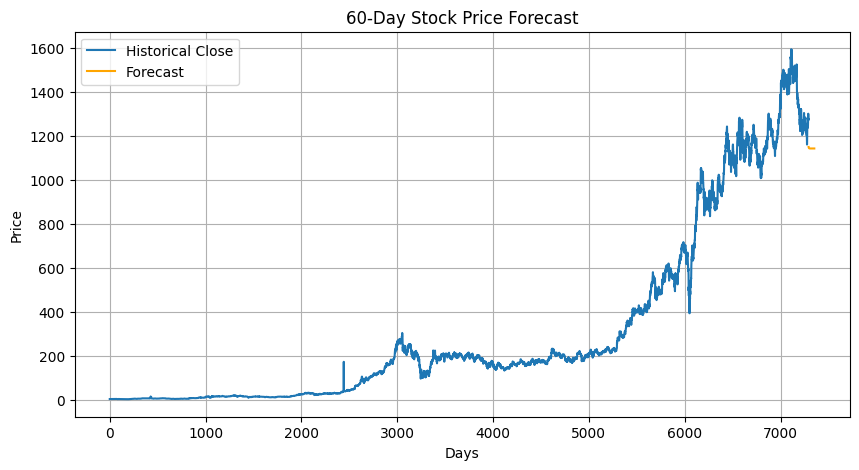

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(df)), df['Close'], label='Historical Close')
plt.plot(range(len(df), len(df)+60), predicted_prices, label='Forecast', color='orange')
plt.title("60-Day Stock Price Forecast")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
